In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

In [16]:
qubit = 0 

In [17]:
scale_factor = 1e-7

def getJobData(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data


def getClosetMultipleof16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require
    durations which are multiples of 16 samples.
    """
    return int(num + 8) - (int(num + 8) % 16)

def count(job, discriminator):
    data = getJobData(job, average=False)
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshapeComplexVector(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

def reshapeComplexVector(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [18]:
NUM_SHOTS = 20000
job_0 = backend.retrieve_job('6320c729ebe26100a6eee65d')
epsilon_raw_iq_data_0 = getJobData(job_0, average=False) 

In [19]:
NUM_SHOTS = 20000
job_1 = backend.retrieve_job('6328174722406153e34d6fa3')
epsilon_raw_iq_data_1 = getJobData(job_1, average=False)

In [20]:
zero_data_reshaped = reshapeComplexVector(epsilon_raw_iq_data_0[0])
one_data_reshaped = reshapeComplexVector(epsilon_raw_iq_data_0[1])
two_data_reshaped = reshapeComplexVector(epsilon_raw_iq_data_0[2])
IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))

state_012 = np.zeros(NUM_SHOTS) 
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))

IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

LinearDiscriminantAnalysis()

In [24]:
zero_data_reshaped = reshapeComplexVector(epsilon_raw_iq_data_1[0])
one_data_reshaped = reshapeComplexVector(epsilon_raw_iq_data_1[1])
two_data_reshaped = reshapeComplexVector(epsilon_raw_iq_data_1[2])
IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))

state_012 = np.zeros(NUM_SHOTS) 
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))

IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

LinearDiscriminantAnalysis()

In [21]:
epsilon_counted_0 = count(job_0, LDA_012)
epsilon_normalized_0 = [[epsilon_counted_0[i]['0'] / 20000, epsilon_counted_0[i]['1'] / 20000, epsilon_counted_0[i]['2'] / 20000] for i in
                   range(np.shape(epsilon_counted_0)[0])]

In [25]:
epsilon_counted_1 = count(job_1, LDA_012)
epsilon_normalized_1 = [[epsilon_counted_1[i]['0'] / 20000, epsilon_counted_1[i]['1'] / 20000, epsilon_counted_1[i]['2'] / 20000] for i in
                   range(np.shape(epsilon_counted_1)[0])]

In [22]:
population_zero_exp_0 = []
population_one_exp_0 = []
population_two_exp_0 = []

for j in range(len(epsilon_normalized_0)):
    if j < 3:
        continue
    else:
        population_zero_exp_0.append(epsilon_normalized_0[j][0])
        population_one_exp_0.append(epsilon_normalized_0[j][1])
        population_two_exp_0.append(epsilon_normalized_0[j][2]) 

In [26]:
population_zero_exp_1 = []
population_one_exp_1 = []
population_two_exp_1 = []

for j in range(len(epsilon_normalized_0)):
    if j < 3:
        continue
    else:
        population_zero_exp_1.append(epsilon_normalized_1[j][0])
        population_one_exp_1.append(epsilon_normalized_1[j][1])
        population_two_exp_1.append(epsilon_normalized_1[j][2]) 

In [34]:
from sympy import *
from sympy.physics.quantum.dagger import Dagger
import numpy as np

population_zero = []
population_one = []
population_two = []

ground = np.array([
    [1], [0], [0]
])

first_excited = np.array([
    [0], [1], [0]
])

second_excited = np.array([
    [0], [0], [1]
])

def RX01(theta, epsilon):
    Rotation = np.array([
        [cos((theta)/2), -1j*sin((theta)/2), 0],
        [-1j*sin((theta)/2), cos((theta)/2), 0],
        [0, 0, 1]])@np.array([
                        [cos((epsilon)/2), -1j*sin((epsilon)/2), 0],
                        [-1j*sin((epsilon)/2), cos((epsilon)/2), 0],
                        [0, 0, 1]])
    return Rotation

# integer = 48
# repetitions = 2*integer+1
# d_range = np.linspace(1, 194, 194)
# epsilon = 0.02

# for d in range(repetitions):
#     initial_state = np.array([[1], [0], [0]])
#     Unitary = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
#     for j in range(d+1):
#         Unitary = RX01(pi/2, epsilon) @ Unitary
#     final_state = Unitary @ initial_state
#     population_zero.append(np.absolute(final_state[0])**2)
#     population_one.append(np.absolute(final_state[1])**2)
#     population_two.append(np.absolute(final_state[2])**2)

# import matplotlib.pylab as pylab
# params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (11, 5),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}
# pylab.rcParams.update(params)   

# import matplotlib.pyplot as plt

In [12]:
# plt.plot(d_range, population_zero, '--s', color='black', label=r'$P_{|0\rangle}$')
# # plt.plot(d_range, population_one, '--', color='orange', label=r'$P_{|1\rangle}$')
# # plt.plot(d_range, population_zero_exp, 'rs', label=r'$\tilde{P}_{|0\rangle}$')
# # plt.plot(d_range, population_one_exp, 'ro', label=r'$\tilde{P}_{|1\rangle}$')
# # plt.plot(d_range, population_two, 'g*', label=r'$P_{|2\rangle}$')
# plt.legend(fontsize=15)
# plt.xlabel(r"# of iteration of $\tilde{X}$, $\epsilon$ = %f" % (epsilon), fontsize=15)
# plt.ylabel(r"Probabilities",fontsize=15)
# # plt.xlim(0, 20)
# plt.savefig('theoretical.png',dpi=300)
# plt.show()

In [31]:
d_range = np.linspace(1, 194, 194)
pop1_exp_concatenated = np.concatenate((population_zero_exp_0, population_zero_exp_1))

In [62]:
epsilon = 0.02-0.005+0.003

population_zero = []
population_one = []
population_two = []

for d in range(194):
    initial_state = np.array([[1], [0], [0]])
    Unitary = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    for j in range(d+1):
        Unitary = RX01(pi/2, epsilon) @ Unitary
    final_state = Unitary @ initial_state
    population_zero.append(np.absolute(final_state[0])**2)
    population_one.append(np.absolute(final_state[1])**2)
    population_two.append(np.absolute(final_state[2])**2)

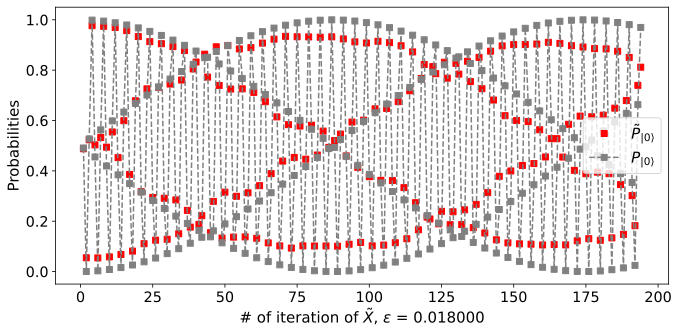

In [64]:
plt.plot(d_range, pop1_exp_concatenated, 'rs', label=r'$\tilde{P}_{|0\rangle}$')
plt.plot(d_range, population_zero, '--s', color='gray', label=r'$P_{|0\rangle}$')
plt.legend(fontsize=15)
plt.xlabel(r"# of iteration of $\tilde{X}$, $\epsilon$ = %f" % (epsilon), fontsize=15)
plt.ylabel(r"Probabilities",fontsize=15)
# plt.xlim(0, 20)
plt.savefig('theoretical2.png',dpi=300)
plt.show()